# BEE 4750 Homework 2: Systems Modeling and Simulation

**Name**: Bailey Belinger, Camila Monter, Priya Shah

**ID**: 5277347 (bcb87), 5244001 (cm755), 5244508 (ps746)

> **Due Date**
>
> Thursday, 09/19/24, 9:00pm

## Overview

### Instructions

-   Problem 1 asks you to derive a model for water quality in a river
    system and use this model to check for regulatory compliance.
-   Problem 2 asks you to explore the dynamics and equilibrium stability
    of the shallow lake model under a particular set of parameter
    values.
-   Problem 3 (5750 only) asks you to modify the lake eutrophication
    example from Lecture 04 to account for atmospheric deposition.

### Load Environment

The following code loads the environment and makes sure all needed
packages are installed. This should be at the start of most Julia
scripts.

In [28]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

  Activating project at `~/Downloads/BEE4750/hw2-last-three-brain-cells`


In [29]:
using Plots
using LaTeXStrings
using CSV
using DataFrames
using Roots

## Problems (Total: 50/60 Points)

### Problem 1 (25 points)

A river which flows at 10 km/d is receiving discharges of wastewater
contaminated with CRUD from two sources which are 15 km apart, as shown
in the Figure below. CRUD decays exponentially in the river at a rate of
0.36 $\mathrm{d}^{-1}$.

<figure>
<img src="attachment:figures/river_diagram.png"
alt="Schematic of the river system in Problem 1" />
<figcaption aria-hidden="true">Schematic of the river system in Problem
1</figcaption>
</figure>

**In this problem**:

-   Assuming steady-state conditions, derive a model for the
    concentration of CRUD downriver by solving the appropriate
    differential equation(s) analytically.
-   Determine if the system in compliance with a regulatory limit of 2.5
    kg/(1000 m$^3$).

We will begin our derivation using the mass balance equation:

$\sum Q_{in}C_{in}=\sum Q_{out}C_{out}$ 

and the continuity of flow rate equation:

$\sum Q_{in}=\sum Q_{out}$

We will first use these equations to find the concentration of CRUD at the first node (x=0 km), where the first source of CRUD enters the river. We will call this node immediately after mixing A,1. The initial concentration and flow rate in the river can be denoted as $C_0$ and $Q_0$ respectively. The concentration and flow rate of the first source of CRUD can be denoted as $C_1$ and $Q_1$ respectively.

$Q_{A} = Q_0 + Q_1$

$Q_{A} = 250,000 \frac{m^3}{d} + 40,000 \frac{m^3}{d} = 290,000 \frac{m^3}{d}$

$Q_0 C_0 + Q_1 C_1 = Q_{A} C_{A,1}$

$C_{A,1} = \frac{Q_0 C_0 + Q_1 C_1 }{Q_{A}} = \frac{\frac{250,000 m^3}{day} \frac{0.5 kg}{1000 m^3}+ \frac{40,000 m^3}{day} \frac{9 kg}{1000 m^3}}{\frac{290,000 m^3}{day}}=\frac{1.67 kg}{1000 m^3}$


We can continue with the general advection-dispersion equation in steady-state conditions: $v \frac{dC}{dx} = -k C$ where v is velocity of the river in km/d, $ \frac{dC}{dx}$ is the rate of change of CRUD concentration with respect to distance, and kC is the change in CRUD due to exponential decay.

We will now solve this differential equation to solve for C, the concentration at any point in the river (x):

Rearranging terms to group variables on the same side of the equals sign

$ \frac{dC}{C} = - \frac{k}{v}dx$

Integrating

$\int \frac{1}{C} \, dC = -\frac{k}{v} \int dx$

lnC = $ \frac{k}{v}x + constant $

Exponentiating to solve for C and rewriting constant as $C_0$, where $C_0$ is the initial concentration of CRUD in the river inflow

$C = e^{-\frac{k}{v} x + C_0}$

We arrive at the general form of equation for concentration of CRUD at any point x downstream in the river based on one input and one initial concentration where x = 0:

$C(x) = C_0e^{-\frac{k}{v}x}$

We can now write this in terms of our previously defined variables to find the concentration of CRUD in the river at the second node (x=15 km), before mixing, denoted $C_{A,2}$.

$C_{A,2} = C_{A,1} e^{-\frac{k}{v} 15 km} = \frac{1.67 kg}{1000 m^3} e^{-0.036 \times 15} =\frac{0.97 kg}{1000 m^3}$

Recall that the decay constant k was stated in the problem to be 0.36 / day and the river velocity v to be 10 km / day. Therefore, inputting those values into their respective variables we arrive at an exponent of = $ - \frac{k}{v} = - \frac{0.36}{10} = 0.036$

Using the mass balance equations again, we can solve for the concentration at node B after mixing with the second source of CRUD entering the river, which we can call $C_2$. 

$Q_{B} = Q_A + Q_2$

$Q_{B} = 290,000 \frac{m^3}{d} + 60,000 \frac{m^3}{d} = 350,000 \frac{m^3}{d}$

$Q_A C_{A,2} + Q_2 C_2 = Q_{B} C_{B}$

$C_{B} = \frac{Q_A C_{A,2} + Q_2 C_2 }{Q_{B}} = \frac{\frac{290,000 m^3}{day} \frac{0.97 kg}{1000 m^3}+ \frac{60,000 m^3}{day} \frac{7 kg}{1000 m^3}}{\frac{350,000 m^3}{day}}=\frac{2 kg}{1000 m^3}$

Since we have the concentration at x=15 km, we can now set up an equation to find the CRUD concentration at any distance x greater than 15km. This can be done using the equation: 

$C(x) = C_B e^{-0.036(x-15)}$, where $C_B = \frac{2 kg}{1000 m^3}$

However, this equation is only applicable after and at the second discharge point (x = 15 km). Any point before this must only consider the initial concentration and discharge #1 of CRUD.

So for x = 0 km to x = 15 km, we must implement the following:

$C(x) = C_{A,1} e^{-0.036x}$, where $C_{A,1} = \frac{1.67 kg}{1000 m^3}$

In order to determine if the system is in compliance with the regulatory limit of $2.5 kg/(1000 m^{3})$ we must write a function that outputs the concentration at a given distance downriver.

In [30]:
# Function to model CRUD concentration at any distance x based on equations derived above 
function CRUD_conc(x,k,Q0,C0,Q1,C1,Q2,C2,v,d,limit)
    QA=Q0+Q1 
    CA1=((Q0*C0)+(Q1*C1))/QA
    CA2=CA1*exp((-k/v)*x)
    QB=QA+Q2
    CB=((QA*CA2)+(Q2*C2))/QB
    # Determine which equation to use based on whether the desired distance is after the 1st or 2nd discharge point 
    if x >= d
        C = CB*exp((-k/v)*(x-d))
    else
        C = CA1*exp((-k/v)*x)
    end
    # Check to see of the concentration at desired distance is compliant
    if C > limit
        print("System is not in compliance with regulatory limit.")
    else
        print("System is in compliance with regulatory limit.")
    end
    return C
end

# Initializing values for this problem:
x = 16
k = 0.36 #1/day 
Q0 = 250000 #m^3/day 
C0 = 0.5 #kg/1000m^3 
Q1 = 40000 #m^3/day
C1 = 9 #kg/1000m^3
Q2 = 60000 #m^3/day
C2 = 7 #kg/1000m^3
v = 10 #km/day 
d = 15 #km, distance between discharge points 
limit = 2.5 #kg/1000m^3

C = CRUD_conc(x,k,Q0,C0,Q1,C1,Q2,C2,v,d,limit)
println(" Concentration at x = $x is $C")

System is in compliance with regulatory limit. Concentration at x = 16 is 1.9089930603434102


After testing multiple distances less than and greater than d, we concluded that the system will always be compliant. This makes sense as the highest concentration calculated at any mixing point is 2 kg/1000 $m^3$.

> **Tip**
>
> Formulate your model in terms of distance downriver, rather than
> leaving it in terms of time from discharge.

### Problem 2 (25 points)

Consider the shallow lake model from class:

$$
\begin{aligned}
X_{t+1} &= X_t + a_t + y_t + \frac{X_t^q}{1 + X_t^q} - bX_t, \\
y_t &\sim \text{LogNormal}(\mu, \sigma^2),
\end{aligned}
$$

where:

-   $X_t$ is the lake phosphorous (P) concentration at time $t$;
-   $a_t$ is the point-source P release at time $t$;
-   $y_t$ is the non-point-source P release at time $t$, which is
    treated as random from a LogNormal distribution with mean $\mu$ and
    standard deviation $\sigma$;
-   $b$ is the linear rate of P outflow;
-   $q$ is a parameter influencing the rate of P recycling from the
    sediment.

**In this problem**:

-   Make an initial conditions plot for the model dynamics for $b=0.5$,
    $q=1.5$, $y_t=0$, and $a_t=0$ for $t=0, \ldots, 30$. What are the
    equilibria? What can you say about the resilience of the system?

    > **Finding equilibria**
    >
    > Use [`Roots.jl`](https://juliamath.github.io/Roots.jl/stable/) to
    > find the equilibria by solving for values where $X_{t+1} = X_t$.
    > For example, if you have functions `X_outflow(X,b)` and
    > `X_recycling(X,q)`, you could create a function
    > `X_delta(x, a) = a + X_recycling(x) - X_outflow(x)` and call
    > `Roots.find_zero(x -> X_delta(x, a), x₀)`, where `x₀` is an
    > initial value for the search (you might need to use your plot to
    > find values for `x₀` near each of the “true” equilibria).

-   Repeat the analysis with $a_t=0.02$ for all $t$. What are the new
    equilibria? How have the dynamics and resilience of the system
    changed?

1.0

0.38196601125010543

0.0

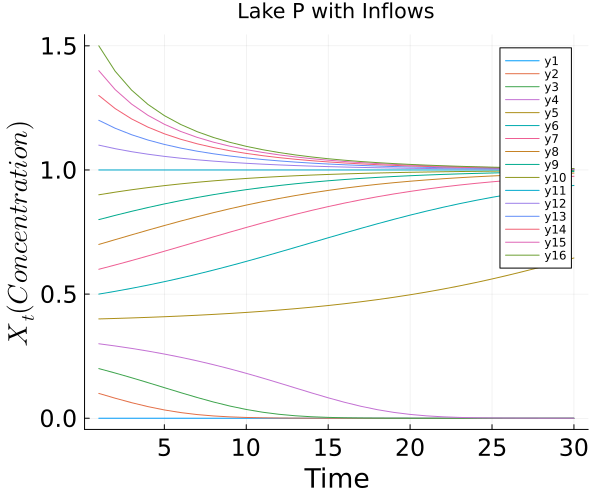

In [37]:
# Initial conditions
b = 0.5
q = 1.5
yt = 0
a = 0

# Function to model phosphorous outflow  
function X_outflow(X,b)
    outflow = b*X
    return outflow
end

# Function to model phosphorous recycling 
function X_recycling(X,q)
    recyling = (abs(X)^q)/(1+abs(X)^q)
    return recyling
end

# Function to calculate net change in phosphorous
function X_delta(X, a, b, q)
    output = a + X_recycling(X, q) - X_outflow(X, b)
    return output
end

# Initial guesses for roots based on initial conditions plot 
x01 = 0.8
x02 = 0.3
x03 = 0.1
# Use roots function with initial guesses to find roots
root1 = Roots.find_zero(x -> X_delta(x, a, b, q), x01)
root2 = Roots.find_zero(x -> X_delta(x, a, b, q), x02)
root3 = Roots.find_zero(x -> X_delta(x, a, b, q), x03)
display(root1)
display(root2)
display(root3)

# Given conditions 
T = 30
X_vals = collect(0.0:0.1:1.5)
a = zeros(T)
y = zeros(T)

# Function to calculate phosphorous concentrations over time 
function simulate_lake_P(X_ic, T, b, q, a, y)
    X = zeros(T)
    X[1] = X_ic
    for t = 2:T
        X[t] = X[t-1] + a[t] + y[t]+ X_recycling(X[t-1], q) - X_outflow(X[t-1], b)
    end
    return X
end

# Maps P concentrations over time based on varying initial P concentrations
X_map = [simulate_lake_P(x, T, 0.5, 1.5, a, y) for x in X_vals]

# Sets up the plot 
p = plot(legend=true, ylabel=L"X_t (Concentration)", xlabel="Time",title="Lake P with Inflows", guidefontsize=18, tickfontsize=16, size=(600, 500))

# Loops through and plots mapped P concentration for each intital P
for X in X_map
    plot!(p, X)
end
display(p)

Looking at this plot, we noticed convergence at $X_t$ values around 0.8 and 0.1. We also noticed divergence when $X_t$ was around 0.3. Hence, we used these three values as our initial guesses for equilibrium points. 

1.1341008852434815

0.15442860418310408

0.11624441966074761

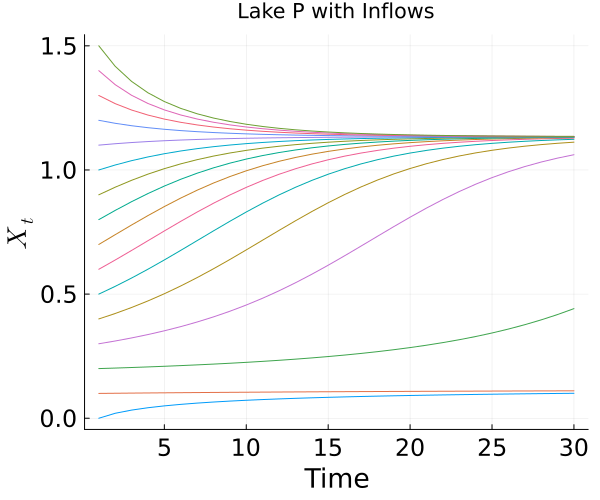

In [32]:
# Define initial conditions
b = 0.5
q = 1.5
yt = 0
a = 0.02

# Define functions for lake recycling and outflows
function X_outflow(X,b)
    outflow = b*X
    return outflow
end

function X_recycling(X,q)
    recyling = (abs(X)^q)/(1+abs(X)^q)
    return recyling
end

function X_delta(X, a, b, q)
    output = a + X_recycling(X, q) - X_outflow(X, b)
    return output
end

# Define two intial guesses for equilibrium values
x01 = 1.2
x02 = 0.3
x03 = 0.1
# Use pre-defined roots function to find roots
root1 = Roots.find_zero(x -> X_delta(x, a, b, q), x01)
root2 = Roots.find_zero(x -> X_delta(x, a, b, q), x02)
root3 = Roots.find_zero(x -> X_delta(x, a, b, q), x03)
display(root1)
display(root2)
display(root3)

T = 30
X_vals = collect(0.0:0.1:1.5)
a = zeros(T)
a = a .+ 0.02
y = zeros(T)
function simulate_lake_P(X_ic, T, b, q, a, y)
    X = zeros(T)
    X[1] = X_ic
    for t = 2:T
        X[t] = X[t-1] + a[t] + y[t]+ X_recycling(X[t-1], q) - X_outflow(X[t-1], b)
    end
    return X
end
X_map = [simulate_lake_P(x, T, 0.5, 1.5, a, y) for x in X_vals]

p = plot(legend=false, ylabel=L"X_t", xlabel="Time",title="Lake P with Inflows", guidefontsize=18, tickfontsize=16, size=(600, 500))

for X in X_map
    plot!(p, X)
end

display(p)

The equilibria are a = 0 are 0, 0.38, and 1 and the new equilibria are 0.11, 0.15, and 1.13. By changing a to 0.02, the equilibria increase, making the system more resilient.
The intial equilibria are relatively low and closer to 0, therefore a smaller disturbance would trigger a bigger event. This shows that the system is not very resilient. For example, if a small inflow of phosphorus entered the system it could cause an abundance of algae and cyanobacteria growth, irreversitly altering the system outcome. A similar inflow of phosphorus into the system where a = 0.02, could cause algae and cyanobacteria growth but the system is more likely to recover from this disturbance.


### Problem 3 (10 points)

**This problem is only required for students in BEE 5750**.

Consider the lake eutrophication example from [Lecture
04](https://viveks.me/environmental-systems-analysis/slides/lecture03-1-eutrophication-modeling.html#/title-slide).
Suppose that phosphorous is also atmospherically deposited onto the lake
surface at a rate of
$1.6 \times 10^{-4} \mathrm{kg/(yr} \cdot \mathrm{m}^2)$, which is then
instantly mixed into the lake. Derive a model for the lake phosphorous
concentration and find the maximum allowable point source phosphorous
loading if the goal is to keep lake concentrations below 0.02 mg/L.

## References

- The mass balance equation, continuity of flow rate equation, and the first-order 1D advection-dispersion equation were all referenced from CEE 3510 - Environmental Quality Engineering